In [1]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import torch
from src.core.utils import cv2_video_fps, cv2_video_frame_count, cv2_video_resolution
from src.logic.glasses.gaze import parse_gazedata_file
from src.logic.pipelines.gaze_sam_pipeline import crop_box, get_viewed_masks
from ultralytics import FastSAM

In [2]:
NUM_MODELS = 3
model = FastSAM("../checkpoints/FastSAM-x.engine")
model2 = FastSAM("../checkpoints/FastSAM-s.pt")
CROP_SIZE = 512
VIDEO_PATH = Path("../data/recordings/af47ccce-c344-49d9-9916-5729e2ddc021.mp4")
GAZE_DATA_PATH = Path("../data/recordings/af47ccce-c344-49d9-9916-5729e2ddc021.tsv")

In [45]:
FOVEA_FOV = 2
FOV_X = 95
resolution = cv2_video_resolution(VIDEO_PATH)
viewed_radius = int((FOVEA_FOV) / FOV_X * resolution[1])

results_per_frame = get_viewed_masks(
    video_path=VIDEO_PATH,
    model=model,
    crop_size=CROP_SIZE,
    resolution=cv2_video_resolution(VIDEO_PATH),
    frame_count=cv2_video_frame_count(VIDEO_PATH),
    fps=cv2_video_fps(VIDEO_PATH),
    gaze_data=parse_gazedata_file(GAZE_DATA_PATH),
    conf=0.5,
    iou=0.8,
    viewed_radius=viewed_radius,
    save_video=True,
)

In [12]:
import faiss
import numpy as np
from transformers import AutoImageProcessor, AutoModel

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base").cuda()


def add_vector_to_index(embedding, index):
    vector = embedding.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    index.add(vector)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [15]:
# 384 is the feature size of the model
index = faiss.IndexFlatL2(768)
start_time = time.time()
total_crop_time = 0
box_crops = []

for frame_idx, results in enumerate(results_per_frame):
    if results.boxes is None:
        continue

    for i, box in enumerate(results.boxes):
        crop_time_start = time.time()
        box_crop = crop_box(results.orig_img, box, mask=results.masks[i])
        box_crops.append(box_crop)
        total_crop_time += time.time() - crop_time_start
        with torch.no_grad():
            inputs = processor(images=box_crop, return_tensors="pt").to(dinov2.device)
            outputs = dinov2(**inputs)
        features = outputs.last_hidden_state
        add_vector_to_index(features.mean(dim=1), index)
total_time = time.time() - start_time
print("FPS", len(results_per_frame) / total_time, "Crop time", total_crop_time)

FPS 61.64976391907964 Crop time 1.270857334136963


Target crop:
Sorted distances: (0.0, 0.052388523, 0.089171425, 0.1837978, 0.21544388, 0.24536979, 0.26181602, 0.26934528, 0.33136812, 0.35153833, 0.37481853, 0.37565038, 0.4102732, 0.43208206, 0.45199764, 0.4703651, 0.474596, 0.47997606, 0.49290884, 0.5068095, 0.50776863, 0.509246, 0.50939983, 0.5130362, 0.53630996, 0.5491725, 0.56072044, 0.58079094, 0.67167515, 0.68038523, 0.6805913, 0.69627047, 0.7509108, 0.78054535, 0.7892757, 0.7936695, 0.8139067, 0.8240734, 0.895866, 0.9217319, 0.94481605, 0.9849327, 0.9886007, 1.0129547, 1.018418, 1.0190569, 1.0329117, 1.0379813, 1.0456872, 1.0471752, 1.0532484, 1.055798, 1.0563691, 1.0570331, 1.0572823, 1.061138, 1.0646261, 1.0649049, 1.0690446, 1.0708332, 1.071264, 1.071815, 1.0738455, 1.0748751, 1.0749711, 1.0782827, 1.0803177, 1.0866143, 1.086936, 1.0873622, 1.0929368, 1.093098, 1.0932566, 1.0946952, 1.0958662, 1.0974938, 1.0981209, 1.0981274, 1.0984242, 1.0984956, 1.098939, 1.0993559, 1.100458, 1.1011622, 1.1016275, 1.1017141, 1.1034762, 1.1

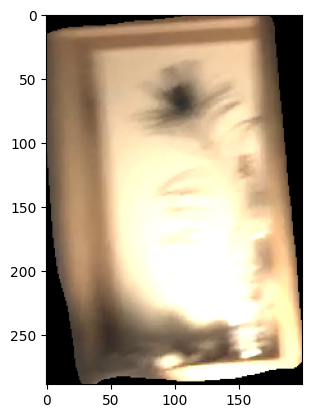

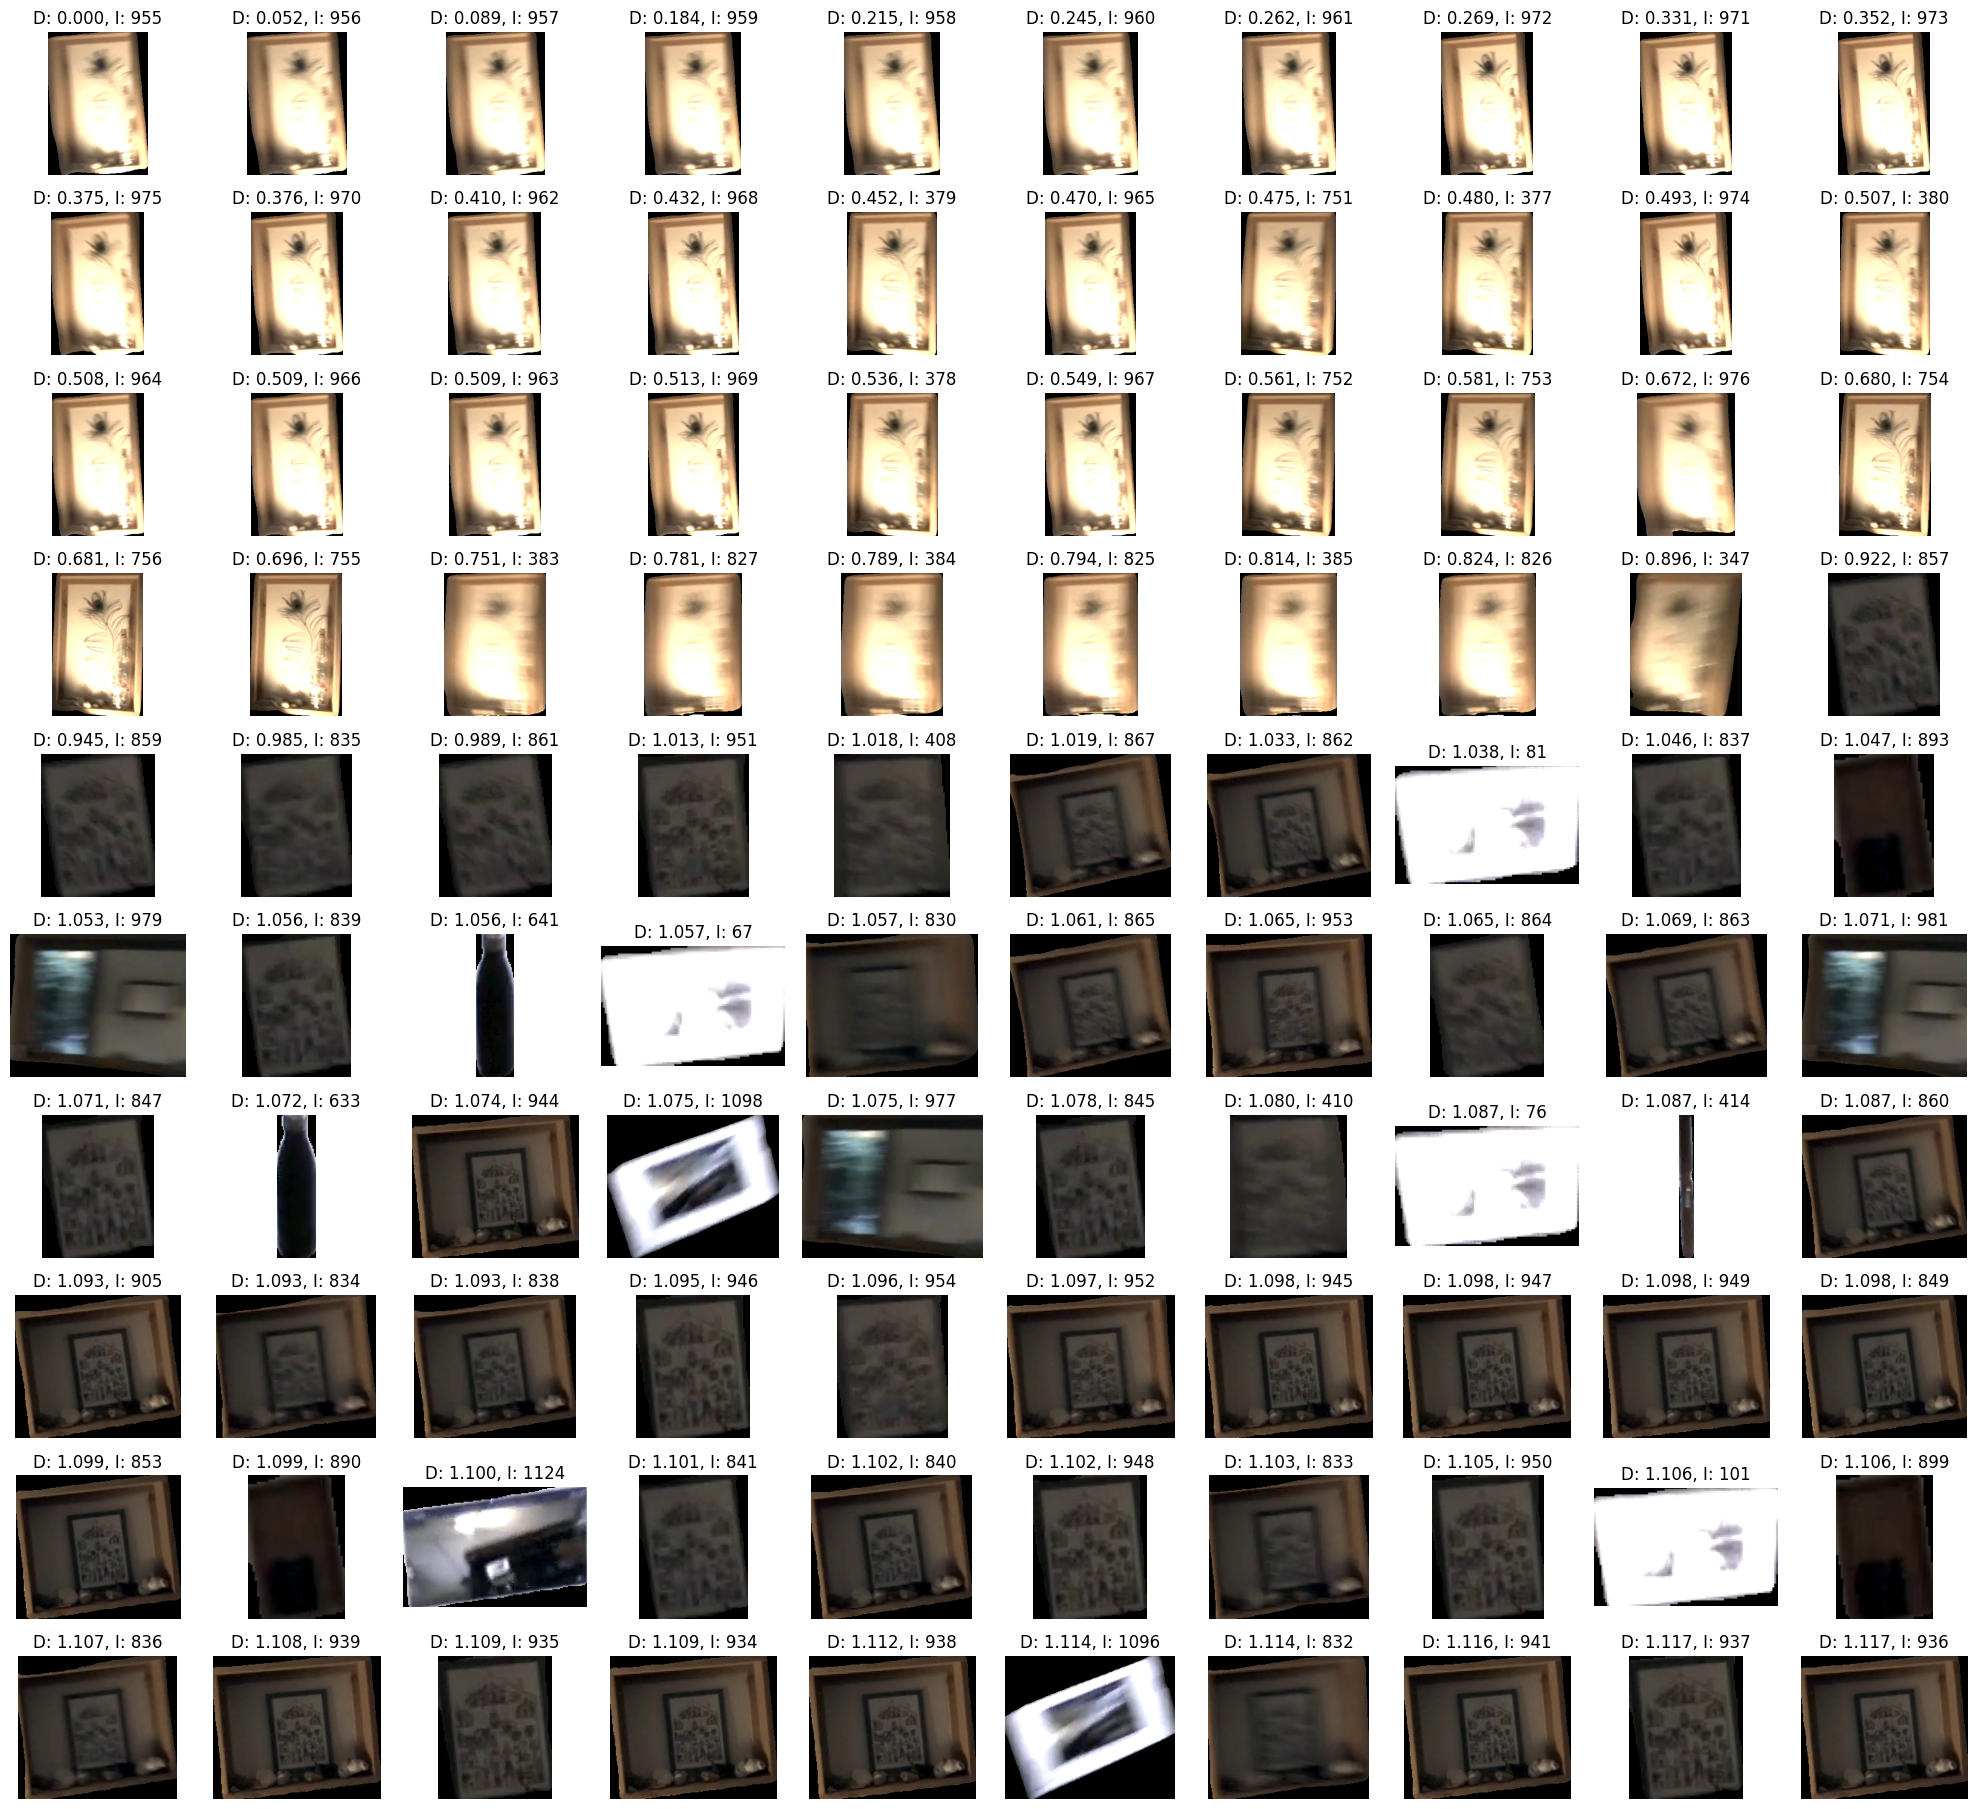

In [30]:
random_i = 733
random_box = results_per_frame[random_i].boxes[0]
box_crop = crop_box(results_per_frame[random_i].orig_img, random_box, mask=results_per_frame[random_i].masks[0])
with torch.no_grad():
    inputs = processor(images=box_crop, return_tensors="pt").to(dinov2.device)
    outputs = dinov2(**inputs)

embeddings = outputs.last_hidden_state.mean(dim=1)
vector = embeddings.detach().cpu().numpy()
vector = np.float32(vector)
faiss.normalize_L2(vector)
d, i = index.search(vector, 100)

print("Target crop:")
plt.imshow(box_crop)

# Sort indices by distance
I, D = i[0], d[0]
sorted_pairs = sorted(zip(D, I, strict=False))  # zip and sort based on distances
D_sorted, I_sorted = zip(*sorted_pairs, strict=False)  # unzip back into separate tuples

print("Sorted distances:", D_sorted)
print("Corresponding indexes:", I_sorted)

fig = plt.figure(figsize=(20, 20))
n_crops = len(I)
n_cols = 10
n_rows = n_crops // n_cols + 1

for idx, box_idx in enumerate(I_sorted[:n_crops]):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(box_crops[box_idx])
    plt.title(f"D: {D_sorted[idx]:.3f}, I: {box_idx}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Target:


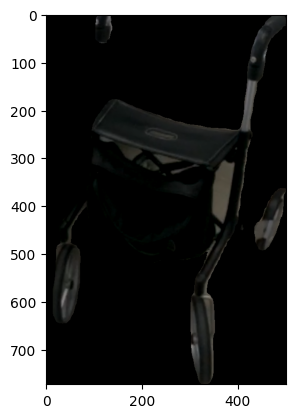

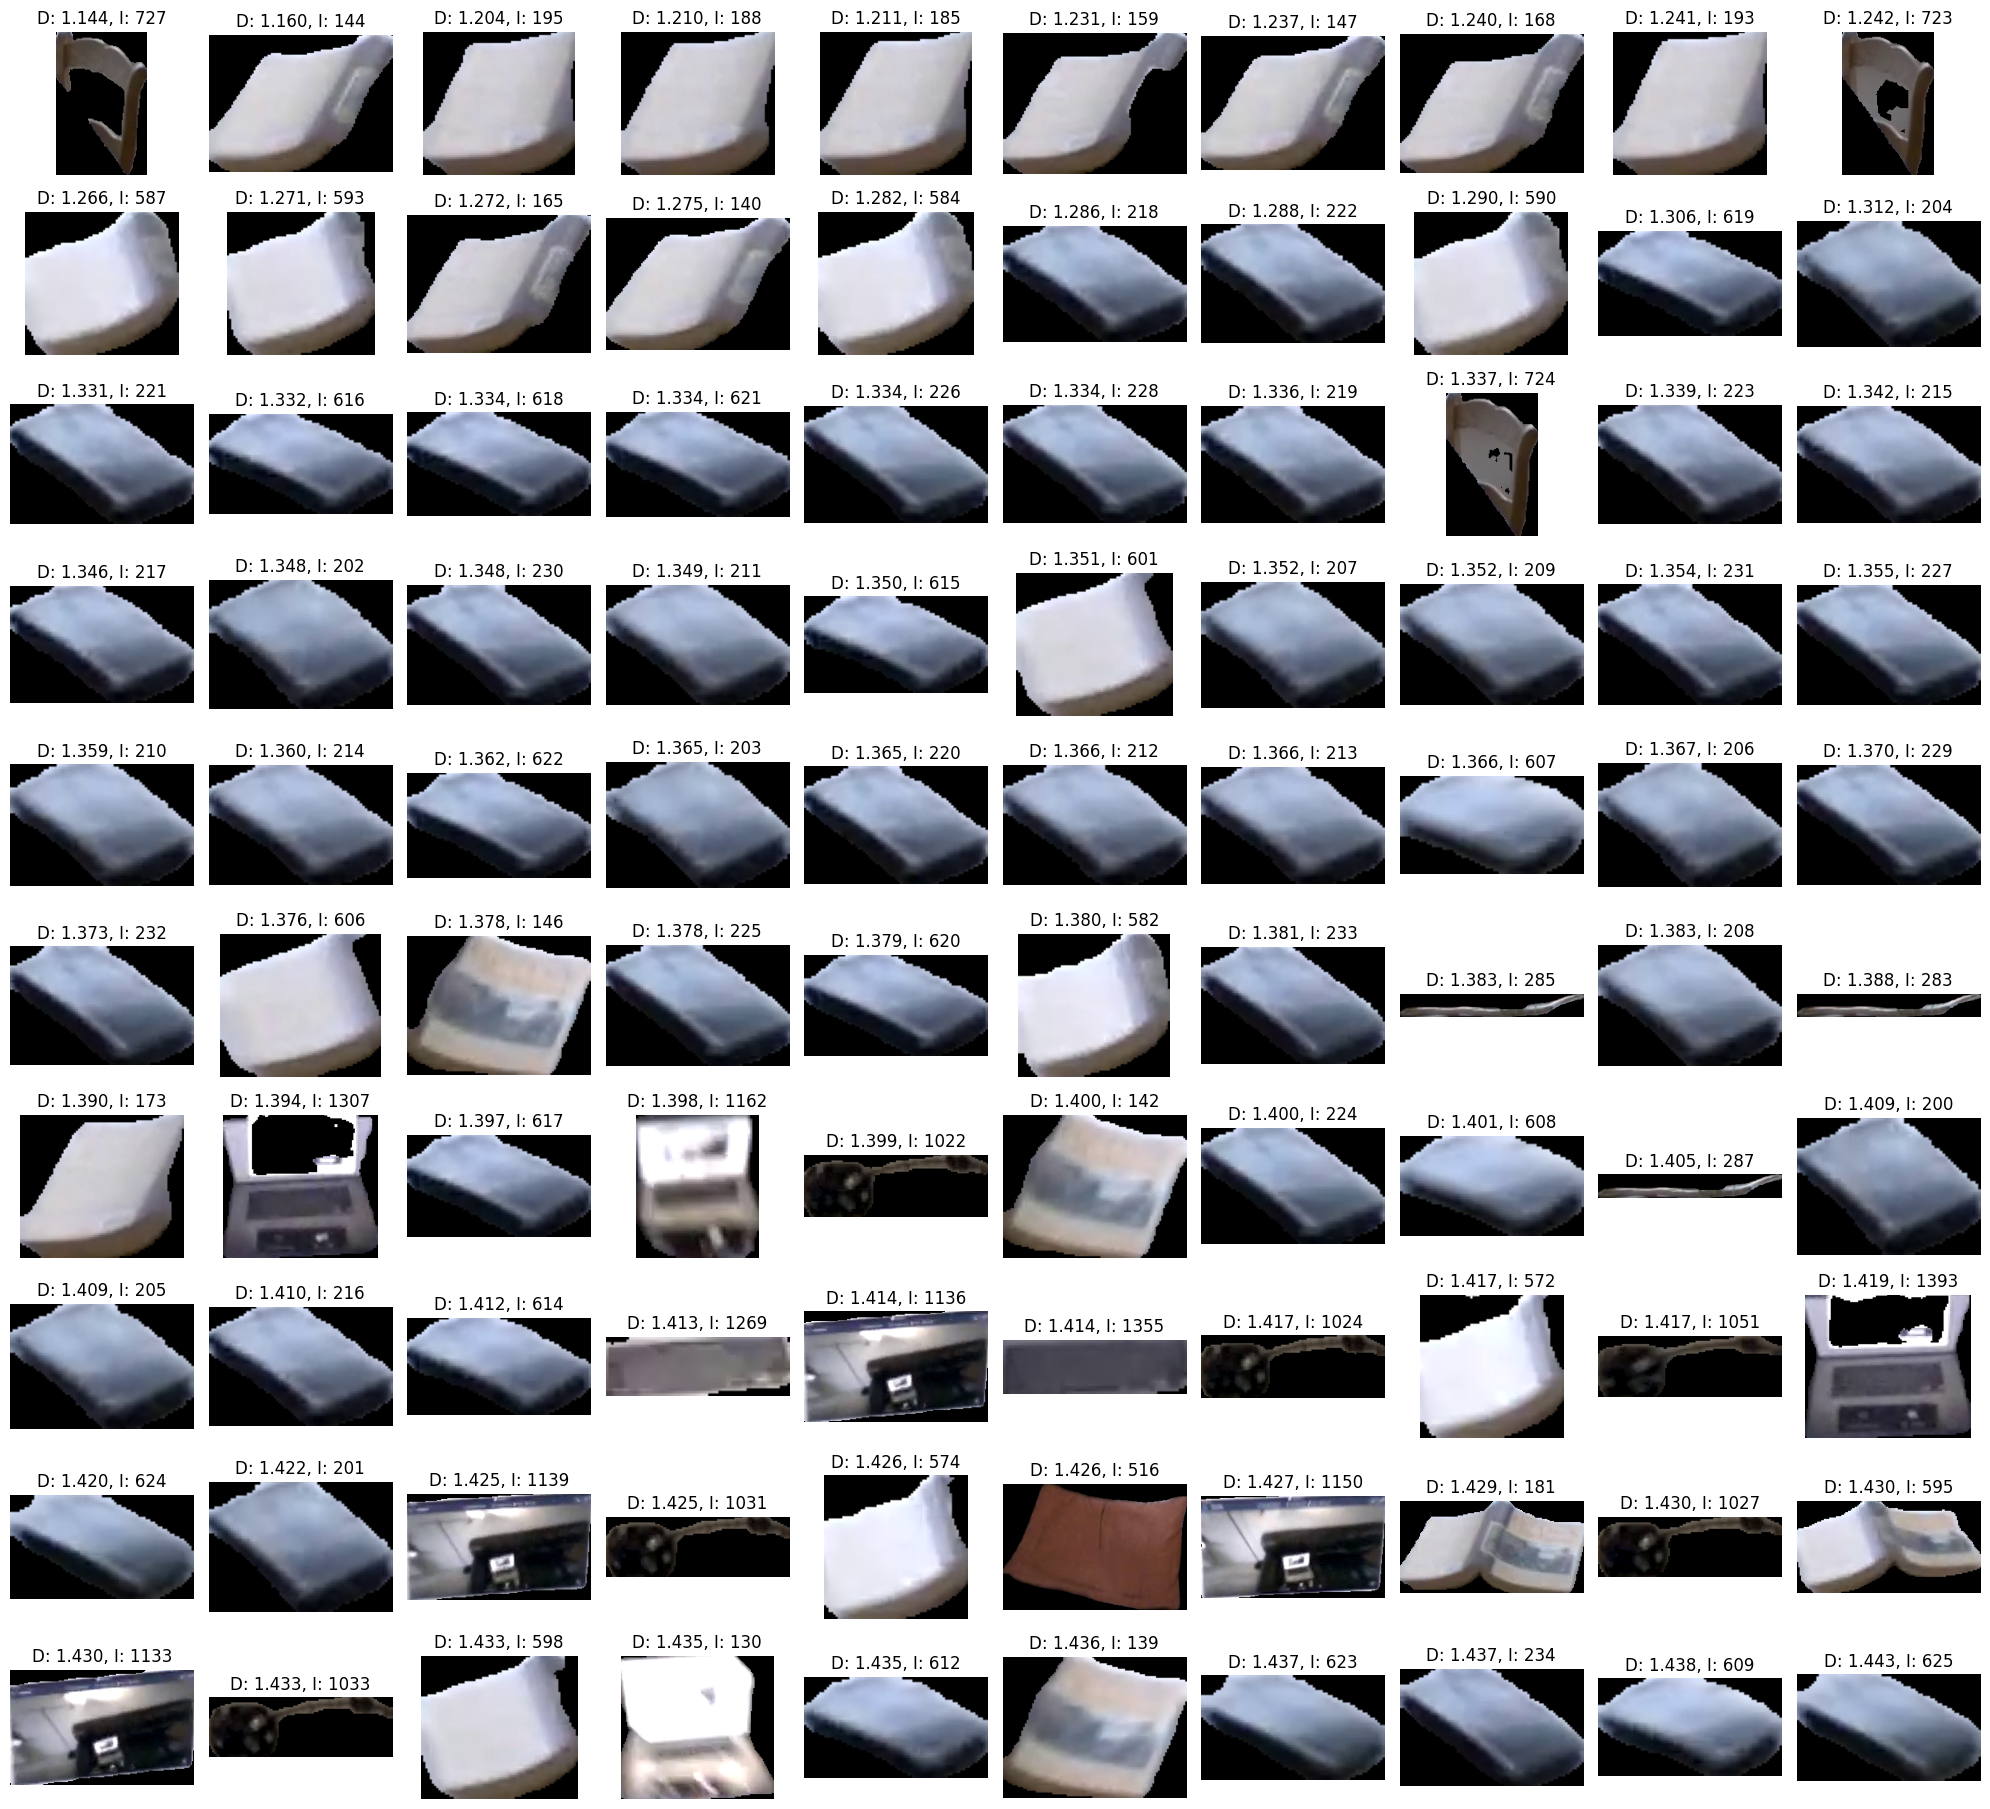

In [43]:
import matplotlib.pyplot as plt

REFERENCE_IMAGES_PATH = Path("./reference_images")
reference_images = REFERENCE_IMAGES_PATH.glob("*.png")

for image in reference_images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    w, h = img.shape[1], img.shape[0]

    results = model(source=img, points=[[w // 2, h // 2]], labels=[1], device="cuda", verbose=False, conf=0.5, iou=0.9)[
        0
    ]

    box_crop = crop_box(results.orig_img, results.boxes[1], mask=results.masks[1])

    with torch.no_grad():
        inputs = processor(images=box_crop, return_tensors="pt").to(dinov2.device)
        outputs = dinov2(**inputs)

    embeddings = outputs.last_hidden_state.mean(dim=1)
    vector = embeddings.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    d, i = index.search(vector, 100)

    print("Target:")
    plt.imshow(box_crop)
    plt.show()

    # Sort indices by distance
    I, D = i[0], d[0]
    sorted_pairs = sorted(zip(D, I, strict=False))  # zip and sort based on distances
    D_sorted, I_sorted = zip(*sorted_pairs, strict=False)  # unzip back into separate tuples

    fig = plt.figure(figsize=(20, 20))
    n_crops = len(I)
    n_cols = 10
    n_rows = n_crops // n_cols + 1

    for idx, box_idx in enumerate(I_sorted[:n_crops]):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(box_crops[box_idx])
        plt.title(f"D: {D_sorted[idx]:.3f}, I: {box_idx}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()